Value Iteration

In [1]:
import os, sys, pdb, math, pickle, time

import matplotlib
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from utils import generate_problem, visualize_value_function

In [3]:
def value_iteration(problem, reward, terminal_mask, gam):
    Ts = problem["Ts"]
    sdim, adim = Ts[0].shape[-1], len(Ts)  # state and action dimension
    V = tf.zeros([sdim])

    assert terminal_mask.ndim == 1 and reward.ndim == 2

    tf_terminal_mask = tf.cast(terminal_mask, tf.bool)

    # perform value iteration
    for _ in range(1000):
        ######### Your code starts here #########
        # perform the value iteration update
        # V has shape [sdim]; sdim = n * n is the total number of grid state
        # Ts is a 4 element python list of transition matrices for 4 actions

        # reward has shape [sdim, 4] - represents the reward for each state
        # action pair

        # terminal_mask has shape [sdim] and has entries 1 for terminal states

        # compute the next value function estimate for the iteration
        Va = []

        for a in range(adim):
            Va.append(tf.where(tf_terminal_mask,
                x=reward[:, a],
                y=reward[:, a] + gam * tf.linalg.matvec(Ts[a], V)))

        V_new = tf.reduce_max(Va, axis=0)

        # compute err = tf.linalg.norm(V_new - V_prev) as a breaking condition
        err = tf.linalg.norm(V_new - V)
        V = V_new

        ######### Your code ends here ###########

        if err < 1e-7:
            break

    return V

In [4]:
# Gather one trajectory according to the policy #################################
def simulate_trajectory(problem, V, R, gam, goal_idx, 
                        max_step=100, init_x=0, init_y=0):
    Ts = problem["Ts"]
    pos2idx = problem["pos2idx"]
    idx2pos = problem["idx2pos"]
    sdim, adim = Ts[0].shape[-1], len(Ts) 
    x_t = pos2idx[init_x, init_y] # initial state

    tau_x = [0]
    tau_y = [0]
    # simulate trajectory up to max_step
    for _ in range(max_step):
        # compute optimal action
        Qs = []
        for u in range(adim):
            Qs.append(R[x_t, u] + gam * tf.reduce_sum(V * Ts[u][x_t]))
        u_t = tf.argmax(Qs, axis=0)

        # sample from transition dynamics
        x_t_plus_1 = np.random.choice(np.arange(sdim), p=Ts[u_t][x_t].numpy())

        pt = idx2pos[x_t_plus_1]
        tau_x.append(pt[0])
        tau_y.append(pt[1])

        if x_t_plus_1 == goal_idx:
            break

        x_t = x_t_plus_1

    plt.plot(tau_x, tau_y, "r")

In [18]:
# value iteration ##############################################################
def value_iteration_run(run_simulation=False):
    # generate the problem
    problem = generate_problem()
    n = problem["n"]
    sdim, adim = n * n, 1

    # create the terminal mask vector
    terminal_mask = np.zeros([sdim])
    terminal_mask[problem["pos2idx"][19, 9]] = 1.0
    terminal_mask = tf.convert_to_tensor(terminal_mask, dtype=tf.float32)

    # generate the reward vector
    reward = np.zeros([sdim, 4])
    reward[problem["pos2idx"][19, 9], :] = 1.0
    reward = tf.convert_to_tensor(reward, dtype=tf.float32)

    gam = 0.95
    V_opt = value_iteration(problem, reward, terminal_mask, gam)

    plt.figure(213)
    visualize_value_function(np.array(V_opt).reshape((n, n)))

    if run_simulation:
      goal_idx = problem["pos2idx"][19, 9]
      simulate_trajectory(problem, V_opt, reward, gam, goal_idx)
      plt.title("Value Iteration - Simulation")
    else:
      plt.title("Value Iteration - Value")
    plt.show()


In [6]:
# retrieve value function from value iteration
def run_value_iteration(problem):
    n = problem["n"]
    sdim = problem["Ts"][0].shape[-1]
    goal_idx = problem["pos2idx"][19, 9]

    # create the terminal mask vector
    terminal_mask = np.zeros([sdim])
    terminal_mask[goal_idx] = 1.0
    terminal_mask = tf.convert_to_tensor(terminal_mask, dtype=tf.float32)

    # generate the reward vector
    reward = np.zeros([sdim, 4])
    reward[goal_idx, :] = 1.0
    reward = tf.convert_to_tensor(reward, dtype=tf.float32)

    gam = 0.95
    V_opt = value_iteration(problem, reward, terminal_mask, gam)

    return V_opt

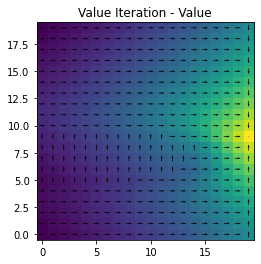

In [7]:
value_iteration_run()

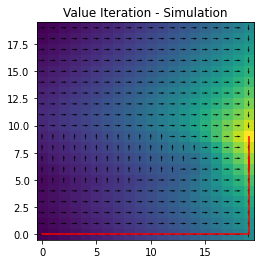

In [19]:
value_iteration_run(True)

In [9]:
import os, sys, pdb, math, pickle, time

import matplotlib
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
from utils import map_chunked, generate_problem, visualize_value_function

In [11]:
def best_action_given_value(V, pos2idx):
    """
    Obtain optimal action for each state given some value table
    Args:
        V: (np.array) the value function reshaped into a 2D array.
    """
    assert V.ndim == 2
    m, n = V.shape
    X, Y = np.meshgrid(np.arange(m), np.arange(n))
    pts = np.stack([X.reshape(-1), Y.reshape(-1)], -1)
    u, v = [], []
    for pt in pts:
        pt_min, pt_max = [0, 0], [m - 1, n - 1]
        pt_right = np.clip(np.array(pt) + np.array([1, 0]), pt_min, pt_max)
        pt_up = np.clip(np.array(pt) + np.array([0, 1]), pt_min, pt_max)
        pt_left = np.clip(np.array(pt) + np.array([-1, 0]), pt_min, pt_max)
        pt_down = np.clip(np.array(pt) + np.array([0, -1]), pt_min, pt_max)
        next_pts = [pt_right, pt_up, pt_left, pt_down]

        Vs = [V[next_pt[0], next_pt[1]] for next_pt in next_pts]
        idx = np.argmax(Vs)
        u.append(next_pts[idx][0] - pt[0])
        v.append(next_pts[idx][1] - pt[1])

    u, v = np.reshape(u, (m, n)), np.reshape(v, (m, n))

    return np.stack([u, v], axis=-1)

In [12]:
def Q_learning(Q_network, reward_fn, is_terminal_fn, X, U, Xp, gam):
    assert X.ndim == 2 and U.ndim == 2 and Xp.ndim == 2
    sdim, adim = X.shape[-1], U.shape[-1]

    @tf.function
    def loss():
        batch_n = int(1e4)
        ridx = tf.random.uniform([batch_n], 0, X.shape[0], dtype=tf.int32)
        X_, U_, Xp_ = [tf.gather(z, ridx) for z in [X, U, Xp]]

        U_all = tf.tile(
            tf.range(4, dtype=tf.float32)[None, :, None], (batch_n, 1, 1)
        )
        Xp_all = tf.tile(Xp_[:, None, :], (1, 4, 1))
        U_all = tf.reshape(U_all, (-1, 1))
        Xp_all = tf.reshape(Xp_all, (-1, sdim))
        input = tf.concat([Xp_all, U_all], -1)
        next_Q = tf.reduce_max(tf.reshape(Q_network(input), (-1, 4)), -1)
        input = tf.concat([X_, U_], -1)
        Q = tf.reshape(Q_network(input), [-1])

        ######### Your code starts here #########
        # compute the loss

        # given the current (Q) and the optimal next state Q function (next_Q), 
        # compute the Q-learning loss

        # make sure to account for the reward, the terminal state and the
        # discount factor gam

        lhs = Q

        r_t = reward_fn(X_, U_)
        is_terminal = is_terminal_fn(X_)
        rhs = tf.where(is_terminal, x=r_t, y=r_t + gam * next_Q)

        l = tf.reduce_mean(tf.square(lhs - rhs))

        ######### Your code ends here ###########

        # need to regularize the Q-value, because we're training its difference
        l = l + 1e-3 * tf.reduce_mean(Q ** 2)
        return l

    ######### Your code starts here #########
    # create the Adam optimizer with tensorflow keras
    # experiment with different learning rates [1e-4, 1e-3, 1e-2, 1e-1]

    optimizer = tf.keras.optimizers.Adam(1e-3)

    ######### Your code ends here ###########

    print("Training the Q-network")
    for _ in tqdm(range(int(1e4))):
        ######### Your code starts here #########
        # apply a single step of gradient descent to the Q_network variables
        # take a look at the tf.keras.optimizers

        optimizer.minimize(loss, Q_network.trainable_variables)

        ######### Your code ends here ###########


In [13]:
# Q-learning # #################################################################
def main():
    problem = generate_problem()
    n = problem["n"]
    sdim, adim = n * n, 1
    Ts = problem["Ts"]  # transistion matrices
    idx2pos = tf.convert_to_tensor(problem["idx2pos"], dtype=tf.float32)

    # sample state action triples
    samp_nb = int(1e5)
    try:
        # load state transitions from disk
        with open("state_transitions.pkl", "rb") as fp:
            temp = pickle.load(fp)
            X, U, Xp = [tf.convert_to_tensor(z, dtype=tf.float32) for z in temp]
    except FileNotFoundError:
        # if the state transistions do not exist, create them
        X = tf.random.uniform([samp_nb], 0, sdim, dtype=tf.int32)
        U = tf.random.uniform([samp_nb], 0, 4, dtype=tf.int32)
        x_list, u_list, xp_list = [], [], []
        print("Sampling state transitions")
        for i in tqdm(range(samp_nb)):
            x = X[i]
            u = U[i]
            ######### Your code starts here #########
            # x is the integer state index in the vectorized state shape: []
            # u is the integer action shape: []
            # compute xp, the integer next state shape: []

            # make use of the transition matrices and tf.random.categorical
            # tf.one_hot can be used to convert an integer state into a vector
            # with 1 in the place of that index

            # remember that transition matrices have a shape [sdim, sdim]
            # remember that tf.random.categorical takes in the log of
            # probabilities, not the probabilities themselves

            log_prob = tf.math.log(Ts[u][x])
            xp = tf.random.categorical(log_prob[tf.newaxis], 1)

            ######### Your code ends here ###########

            # convert integer states to a 2D representation using idx2pos
            xp = tf.reshape(xp, [])
            x_list.append(idx2pos[x])
            u_list.append(tf.reshape(tf.cast(u, tf.float32), [1]))
            xp_list.append(idx2pos[xp])
        X, U, Xp = tf.stack(x_list), tf.stack(u_list), tf.stack(xp_list)
        with open("state_transitions.pkl", "wb") as fp:
            pickle.dump((X.numpy(), U.numpy(), Xp.numpy()), fp)

    # define the reward ####################################
    reward_vec = np.zeros([sdim])
    reward_vec[problem["pos2idx"][19, 9]] = 1.0
    reward_vec = tf.convert_to_tensor(reward_vec, dtype=tf.float32)

    def reward_fn(X, U):
        return tf.cast(
            tf.reduce_all(X == tf.constant([19.0, 9.0]), -1), tf.float32
        )

    def is_terminal_fn(X):
        return tf.reduce_all(X == tf.constant([19.0, 9.0]), -1)

    ######### Your code starts here #########
    # create the deep Q-network
    # it needs to take in 2 state + 1 action input (3 inputs)
    # it needs to output a single value (batch x 1 output) - the Q-value
    # it should be 3 layers deep with

    Q_network = tf.keras.Sequential([
        tf.keras.layers.Dense(64, "tanh"),
        tf.keras.layers.Dense(64, "tanh"),
        tf.keras.layers.Dense(1),
    ])
    Q_network.build((None, 2 + 1)) # input is (state_x, state_y, u)

    ######### Your code ends here ###########

    # train the Q-network ##################################
    gam = 0.95
    Q_learning(Q_network, reward_fn, is_terminal_fn, X, U, Xp, gam)
    ########################################################

    # visualize the Q-network ##############################
    # sample all states
    y, x = [
        tf.reshape(tf.convert_to_tensor(z, dtype=tf.float32), [-1])
        for z in np.meshgrid(np.arange(n), np.arange(n))
    ]
    X_ = tf.range(n * n)
    X_ = tf.tile(
        tf.stack([tf.gather(x, X_), tf.gather(y, X_)], -1)[:, None, :],
        (1, 4, 1),
    )

    # compute optimal value of the Q-network at each state (max over actions)
    # and compute the value function from the Q-network
    U_ = tf.tile(tf.range(4, dtype=tf.float32)[None, :, None], (sdim, 1, 1))
    X_, U_ = tf.reshape(X_, (-1, 2)), tf.reshape(U_, (-1, 1))
    q_input = tf.concat([X_, U_], -1)
    V = tf.reduce_max(tf.reshape(Q_network(q_input), (-1, 4)), -1)

    # visualize the result
    plt.figure(120)
    visualize_value_function(V.numpy().reshape((n, n)))
    plt.colorbar()
    plt.show()
    ########################################################

    # compare optimal action with value iteration
    ########################################################
    # q learning
    actions_ql = best_action_given_value(V.numpy().reshape((n, n)), problem["pos2idx"])
    # value iteration
    V_vi = run_value_iteration(problem)
    actions_vi = best_action_given_value(V_vi.numpy().reshape((n, n)), problem["pos2idx"])

    action_same = np.all(actions_ql == actions_vi, axis=-1)
    plt.imshow(action_same, origin="lower")
    plt.colorbar()
    plt.show()


Training the Q-network


100%|██████████| 10000/10000 [10:05<00:00, 16.51it/s]


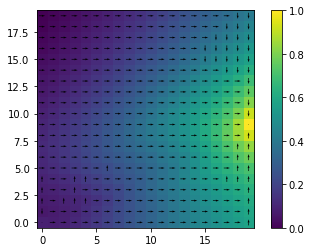

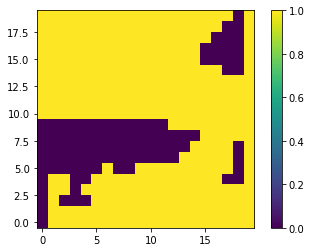

In [14]:
if __name__ == "__main__":
    main()
